# Phase 2: Feature Engineering for Dual-Target Model

**Objective**: Generate features to predict:
- `target_reg`: Next-hour GK volatility (regression)
- `target_class`: Next-hour candle direction (classification)

**Input**: `cleaned_data_with_dual_targets.csv`  
**Output**: `engineered_features_dual_target.csv`

**Feature Categories**:
1. Price-based: Returns, momentum
2. Volatility: ATR, Bollinger Bands, ranges
3. Volume: Ratios, z-scores
4. Technical indicators: RSI, MACD
5. Lags: Volatility and return memory
6. Temporal: Hour, day patterns

In [33]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


In [34]:
# Load cleaned data with dual targets
df = pd.read_csv('cleaned_data_with_dual_targets.csv')
df['open time'] = pd.to_datetime(df['open time'])
df = df.sort_values('open time').reset_index(drop=True)

print(f"Loaded {len(df):,} rows")
print(f"Date range: {df['open time'].min()} to {df['open time'].max()}")
print(f"\nColumns: {list(df.columns)}")

Loaded 70,919 rows
Date range: 2018-01-01 00:00:00 to 2026-02-02 22:00:00

Columns: ['open time', 'open', 'high', 'low', 'close', 'volume', 'close time', 'quote asset volume', 'number of trades', 'taker buy base asset volume', 'taker buy quote asset volume', 'ignore', 'is_interpolated', 'gk_volatility', 'target_reg', 'target_class']


In [35]:
# First create log_return_1h (needed for volatility calculations)
df['log_return_1h'] = np.log(df['close'] / df['close'].shift(1))

# ATR (Average True Range)
df['atr_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

# Bollinger Bands - using direct calculation for reliability
rolling_mean = df['close'].rolling(window=20).mean()
rolling_std = df['close'].rolling(window=20).std()
df['bb_upper'] = rolling_mean + (rolling_std * 2)
df['bb_lower'] = rolling_mean - (rolling_std * 2)
df['bb_middle'] = rolling_mean
df['bb_width_pct'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle'] * 100

# Rolling volatility (std of returns)
df['close_vol_6h'] = df['log_return_1h'].rolling(6).std()
df['close_vol_12h'] = df['log_return_1h'].rolling(12).std()
df['close_vol_24h'] = df['log_return_1h'].rolling(24).std()

# ATR as % of close (normalized)
df['atr_pct'] = df['atr_14'] / df['close'] * 100

print("Volatility features created:")
print("- ATR (14)")
print("- Bollinger Band width %")
print("- Rolling volatility (6h, 12h, 24h)")
print("- ATR %")
print(f"Total: 6 features (dropped intermediate BB columns)")

Volatility features created:
- ATR (14)
- Bollinger Band width %
- Rolling volatility (6h, 12h, 24h)
- ATR %
Total: 6 features (dropped intermediate BB columns)


In [36]:
# Taker buy ratio (buy pressure)
df['taker_buy_ratio'] = df['taker buy base asset volume'] / df['volume']

# Volume z-score (abnormal activity)
df['volume_mean_24h'] = df['volume'].rolling(24).mean()
df['volume_std_24h'] = df['volume'].rolling(24).std()
df['volume_z_score'] = (df['volume'] - df['volume_mean_24h']) / df['volume_std_24h']

# Trade count intensity
df['trade_intensity'] = df['number of trades'] / df['number of trades'].rolling(24).mean()

# Volume change (with inf handling)
df['volume_change_pct'] = df['volume'].pct_change() * 100
df['volume_change_pct'] = df['volume_change_pct'].replace([np.inf, -np.inf], np.nan)

print("Volume features created:")
print("- Taker buy ratio")
print("- Volume z-score")
print("- Trade intensity")
print("- Volume change % (inf values replaced with NaN)")
print(f"Total: 4 features (dropped intermediate volume stats)")

Volume features created:
- Taker buy ratio
- Volume z-score
- Trade intensity
- Volume change % (inf values replaced with NaN)
Total: 4 features (dropped intermediate volume stats)


In [37]:
# === 1. PRICE-BASED FEATURES ===
# Log returns at different horizons
df['log_return_3h'] = np.log(df['close'] / df['close'].shift(3))
df['log_return_6h'] = np.log(df['close'] / df['close'].shift(6))
df['log_return_12h'] = np.log(df['close'] / df['close'].shift(12))

# Return acceleration (momentum change)
df['return_acceleration'] = df['log_return_1h'] - df['log_return_1h'].shift(1)

# High-low range as % of close
df['hl_range_pct'] = (df['high'] - df['low']) / df['close'] * 100

# Close position in range (0 = at low, 1 = at high)
df['close_position'] = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-8)

print("Price-based features created:")
print("- Log returns (1h, 3h, 6h, 12h)")
print("- Return acceleration")
print("- High-low range %")
print("- Close position in range")
print(f"Total: 7 features")

Price-based features created:
- Log returns (1h, 3h, 6h, 12h)
- Return acceleration
- High-low range %
- Close position in range
Total: 7 features


In [38]:
# === 2. TECHNICAL INDICATORS ===
# RSI (Relative Strength Index)
df['rsi_14'] = ta.rsi(df['close'], length=14)

# MACD
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
if macd is not None:
    df['macd'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_histogram'] = macd['MACDh_12_26_9']
else:
    # Manual MACD calculation as fallback
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_histogram'] = df['macd'] - df['macd_signal']

# Stochastic Oscillator
stoch = ta.stoch(df['high'], df['low'], df['close'], k=14, d=3)
if stoch is not None:
    df['stoch_k'] = stoch['STOCHk_14_3_3']
    df['stoch_d'] = stoch['STOCHd_14_3_3']
else:
    # Manual calculation
    low_14 = df['low'].rolling(14).min()
    high_14 = df['high'].rolling(14).max()
    df['stoch_k'] = ((df['close'] - low_14) / (high_14 - low_14 + 1e-8)) * 100
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()

# EMA crossover signal
ema_9 = df['close'].ewm(span=9, adjust=False).mean()
ema_21 = df['close'].ewm(span=21, adjust=False).mean()
df['ema_crossover'] = (ema_9 > ema_21).astype(int)

print("Technical indicators created:")
print("- RSI (14)")
print("- MACD (line, signal, histogram)")
print("- Stochastic (K, D)")
print("- EMA crossover (9/21)")
print(f"Total: 7 features")

Technical indicators created:
- RSI (14)
- MACD (line, signal, histogram)
- Stochastic (K, D)
- EMA crossover (9/21)
Total: 7 features


In [39]:
# === 3. LAG FEATURES (Memory) ===
# GK volatility lags
df['gk_lag_1h'] = df['gk_volatility'].shift(1)
df['gk_lag_3h'] = df['gk_volatility'].shift(3)
df['gk_lag_6h'] = df['gk_volatility'].shift(6)

# GK volatility rolling averages
df['gk_avg_3h'] = df['gk_volatility'].rolling(3).mean()
df['gk_avg_6h'] = df['gk_volatility'].rolling(6).mean()

# ATR lags
df['atr_lag_1h'] = df['atr_14'].shift(1)
df['atr_lag_3h'] = df['atr_14'].shift(3)

# Return lags
df['return_lag_1h'] = df['log_return_1h'].shift(1)
df['return_lag_3h'] = df['log_return_1h'].shift(3)
df['return_lag_6h'] = df['log_return_1h'].shift(6)

print("Lag features created:")
print("- GK volatility lags (1h, 3h, 6h)")
print("- GK volatility averages (3h, 6h)")
print("- ATR lags (1h, 3h)")
print("- Return lags (1h, 3h, 6h)")
print(f"Total: 10 features")

Lag features created:
- GK volatility lags (1h, 3h, 6h)
- GK volatility averages (3h, 6h)
- ATR lags (1h, 3h)
- Return lags (1h, 3h, 6h)
Total: 10 features


In [40]:
# === 4. TEMPORAL FEATURES ===
# Extract hour and day of week
df['hour'] = df['open time'].dt.hour
df['day_of_week'] = df['open time'].dt.dayofweek

# Cyclical encoding (sin/cos) for hour (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding for day of week (0-6)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Funding hour (every 8 hours in crypto: 0, 8, 16 UTC)
df['is_funding_hour'] = df['hour'].isin([0, 8, 16]).astype(int)

# Weekend (Saturday=5, Sunday=6)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Drop intermediate columns
df = df.drop(['hour', 'day_of_week'], axis=1)

print("Temporal features created:")
print("- Hour (sin, cos)")
print("- Day of week (sin, cos)")
print("- Is funding hour")
print("- Is weekend")
print(f"Total: 6 features")

Temporal features created:
- Hour (sin, cos)
- Day of week (sin, cos)
- Is funding hour
- Is weekend
Total: 6 features


In [41]:
# === 5. CLEANUP & DATA QUALITY ===
# Drop intermediate columns used for calculation
columns_to_drop = ['bb_upper', 'bb_lower', 'bb_middle', 'volume_mean_24h', 'volume_std_24h']
existing_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(existing_to_drop, axis=1)

print(f"Dropped {len(existing_to_drop)} intermediate columns: {existing_to_drop}")

# Check for infinite values in all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

if inf_counts:
    print(f"\nInfinite values found and replaced with NaN:")
    for col, count in inf_counts.items():
        print(f"  - {col}: {count} values")
else:
    print("\nNo infinite values found")

# Check NaN counts
nan_counts = df.isna().sum()
high_nan_features = nan_counts[nan_counts > len(df) * 0.5]
if len(high_nan_features) > 0:
    print(f"\nWARNING: {len(high_nan_features)} features have >50% NaN values:")
    for col in high_nan_features.index:
        print(f"  - {col}: {nan_counts[col]} NaN ({nan_counts[col]/len(df)*100:.1f}%)")

print(f"\nDataframe shape after cleanup: {df.shape}")

Dropped 5 intermediate columns: ['bb_upper', 'bb_lower', 'bb_middle', 'volume_mean_24h', 'volume_std_24h']

No infinite values found

Dataframe shape after cleanup: (70919, 56)


In [44]:
print(f"\nDataframe shape: {df.shape}")
df.head(2)


Dataframe shape: (70919, 56)


,open time,open,high,low,close,volume,close time,quote asset volume,number of trades,taker buy base asset volume,...,atr_lag_3h,return_lag_1h,return_lag_3h,return_lag_6h,hour_sin,hour_cos,day_sin,day_cos,is_funding_hour,is_weekend
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,2018-01-01 00:59:59.999,5.993910e+06,5228.0,228.521921,...,NaN,NaN,NaN,NaN,0.000000,1.000000,0.0,1.0,1,0
1,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,2018-01-01 01:59:59.999,5.154522e+06,4534.0,180.840403,...,NaN,NaN,NaN,NaN,0.258819,0.965926,0.0,1.0,0,0


In [45]:
# === FEATURE ENGINEERING SUMMARY ===
# Identify feature columns (exclude base data + targets)
base_columns = ['open time', 'open', 'high', 'low', 'close', 'volume', 
                'close time', 'quote asset volume', 'number of trades',
                'taker buy base asset volume', 'taker buy quote asset volume',
                'gk_volatility', 'target_reg', 'target_class', 'is_interpolated', 'ignore']

feature_columns = [col for col in df.columns if col not in base_columns]

print(f"{'='*60}")
print(f"FEATURE ENGINEERING COMPLETE")
print(f"{'='*60}")
print(f"Total features created: {len(feature_columns)}")

# Categorize features
price_features = [c for c in feature_columns if 'return' in c or 'hl_range' in c or 'close_position' in c or 'acceleration' in c]
vol_features = [c for c in feature_columns if 'atr' in c or 'bb_' in c or 'vol' in c]
volume_features = [c for c in feature_columns if 'volume' in c or 'trade_intensity' in c or 'taker' in c]
tech_features = [c for c in feature_columns if any(x in c for x in ['rsi', 'macd', 'stoch', 'ema'])]
lag_features = [c for c in feature_columns if 'lag' in c or 'avg' in c]
temporal_features = [c for c in feature_columns if any(x in c for x in ['hour', 'day', 'funding', 'weekend'])]

print(f"\n=== FEATURE BREAKDOWN ===")
print(f"1. Price-based: {len(price_features)}")
for f in price_features:
    print(f"   - {f}")
print(f"\n2. Volatility: {len(vol_features)}")
for f in vol_features:
    print(f"   - {f}")
print(f"\n3. Volume: {len(volume_features)}")
for f in volume_features:
    print(f"   - {f}")
print(f"\n4. Technical: {len(tech_features)}")
for f in tech_features:
    print(f"   - {f}")
print(f"\n5. Lags: {len(lag_features)}")
for f in lag_features:
    print(f"   - {f}")
print(f"\n6. Temporal: {len(temporal_features)}")
for f in temporal_features:
    print(f"   - {f}")



import os

FEATURE ENGINEERING COMPLETE
Total features created: 40

=== FEATURE BREAKDOWN ===
1. Price-based: 10
   - log_return_1h
   - log_return_3h
   - log_return_6h
   - log_return_12h
   - return_acceleration
   - hl_range_pct
   - close_position
   - return_lag_1h
   - return_lag_3h
   - return_lag_6h

2. Volatility: 10
   - atr_14
   - bb_width_pct
   - close_vol_6h
   - close_vol_12h
   - close_vol_24h
   - atr_pct
   - volume_z_score
   - volume_change_pct
   - atr_lag_1h
   - atr_lag_3h

3. Volume: 4
   - taker_buy_ratio
   - volume_z_score
   - trade_intensity
   - volume_change_pct

4. Technical: 7
   - rsi_14
   - macd
   - macd_signal
   - macd_histogram
   - stoch_k
   - stoch_d
   - ema_crossover

5. Lags: 10
   - gk_lag_1h
   - gk_lag_3h
   - gk_lag_6h
   - gk_avg_3h
   - gk_avg_6h
   - atr_lag_1h
   - atr_lag_3h
   - return_lag_1h
   - return_lag_3h
   - return_lag_6h

6. Temporal: 6
   - hour_sin
   - hour_cos
   - day_sin
   - day_cos
   - is_funding_hour
   - is_weekend


Rows for correlation analysis: 70,919 (dropped 0 rows with NaN in TARGETS)

Checking NaN in FEATURES:

31 features have some NaN values (expected due to rolling windows/lags):
Feature                        |  NaN Count | % of Data
-------------------------------------------------------
log_return_1h                  |          1 |    0.00%
atr_14                         |         13 |    0.02%
bb_width_pct                   |         19 |    0.03%
close_vol_6h                   |          6 |    0.01%
close_vol_12h                  |         12 |    0.02%
close_vol_24h                  |         24 |    0.03%
atr_pct                        |         13 |    0.02%
taker_buy_ratio                |        125 |    0.18%
volume_z_score                 |         33 |    0.05%
trade_intensity                |         33 |    0.05%
volume_change_pct              |        126 |    0.18%
log_return_3h                  |          3 |    0.00%
log_return_6h                  |          6 |    0.0

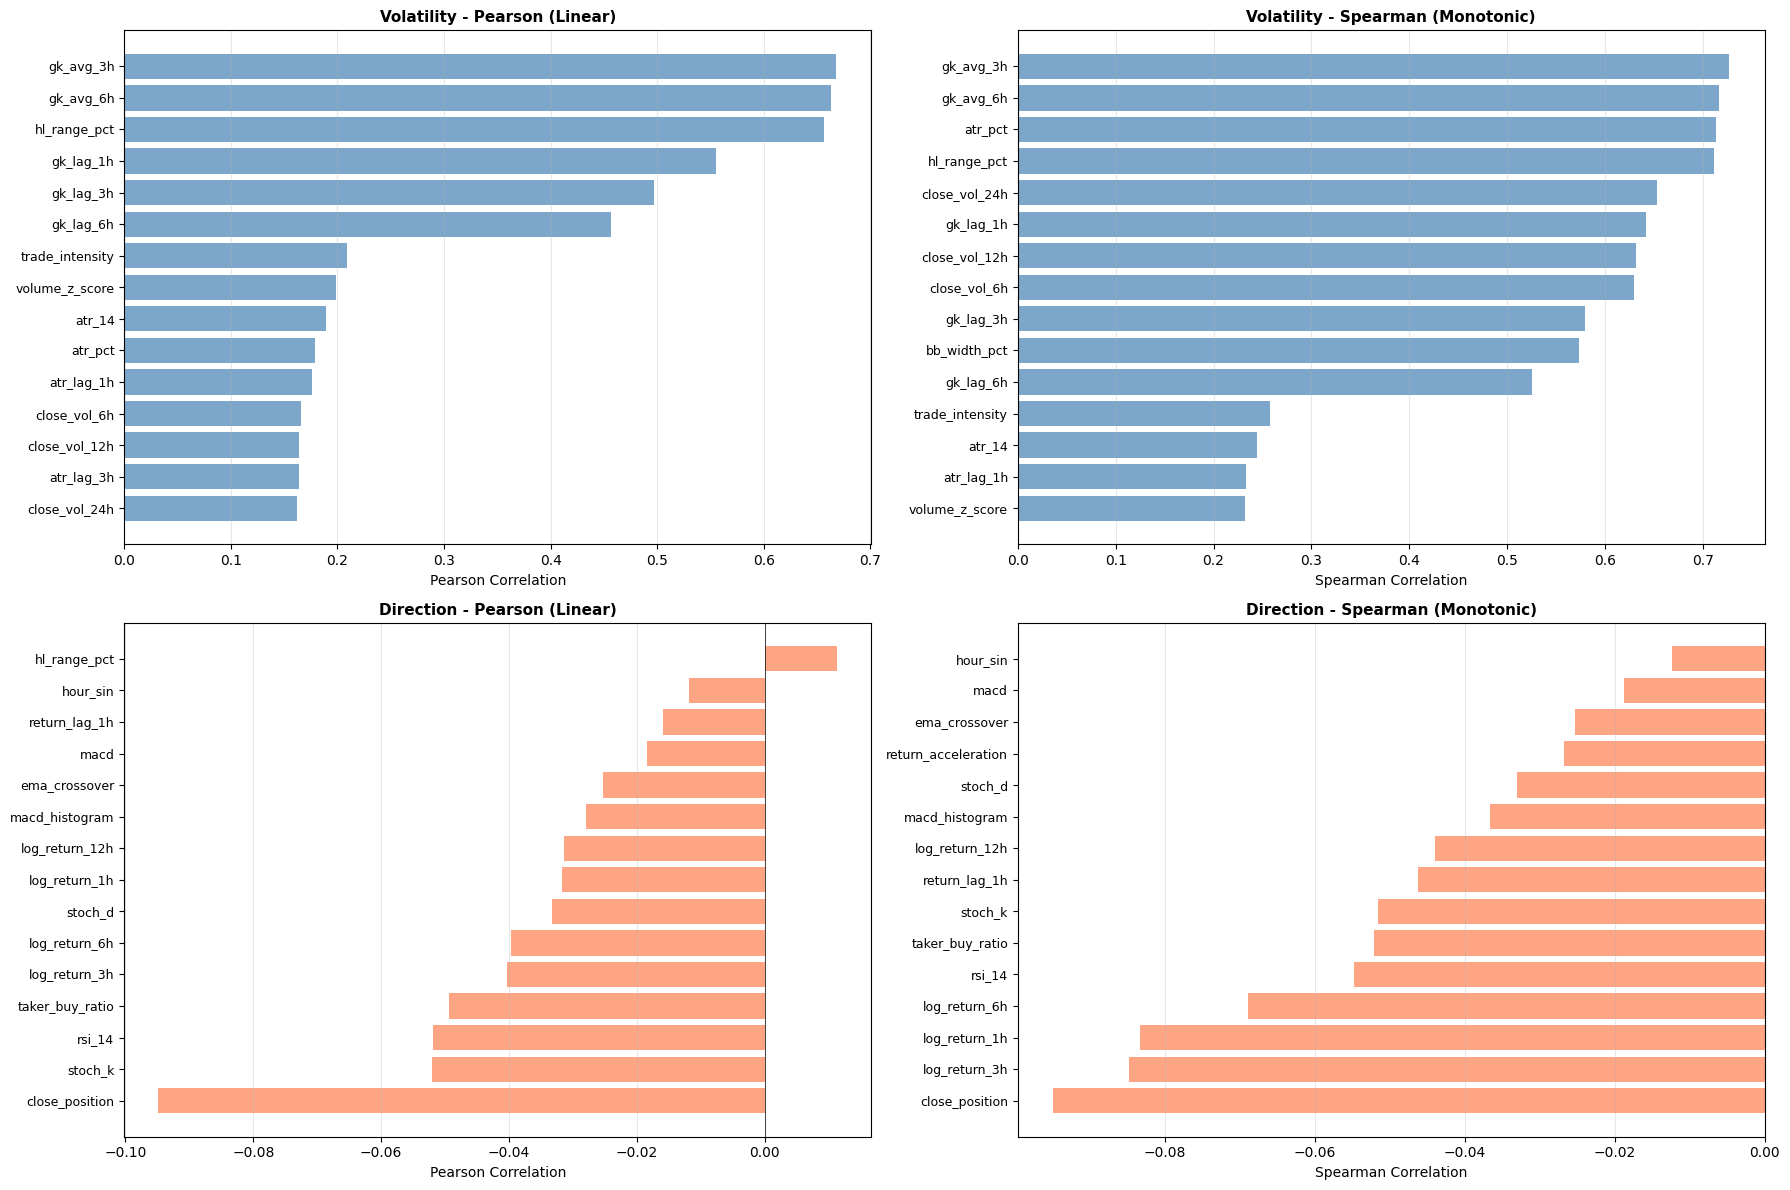

In [46]:
# === CORRELATION ANALYSIS (Pearson & Spearman) ===
import matplotlib.pyplot as plt
import seaborn as sns

# Remove rows with NaN in targets (can't train on these anyway)
df_corr = df.dropna(subset=['target_reg', 'target_class'])

print(f"Rows for correlation analysis: {len(df_corr):,} (dropped {len(df) - len(df_corr):,} rows with NaN in TARGETS)")

# Check NaN counts in FEATURES (features can have some NaN due to rolling windows/lags)
print(f"\nChecking NaN in FEATURES:")
feature_nan_counts = df_corr[feature_columns].isna().sum()
features_with_nan = feature_nan_counts[feature_nan_counts > 0]

if len(features_with_nan) > 0:
    print(f"\n{len(features_with_nan)} features have some NaN values (expected due to rolling windows/lags):")
    print(f"{'Feature':<30} | {'NaN Count':>10} | {'% of Data':>8}")
    print("-" * 55)
    for feat, count in features_with_nan.items():
        pct = count / len(df_corr) * 100
        print(f"{feat:<30} | {count:>10,} | {pct:>7.2f}%")
    
    max_nan_pct = (features_with_nan.max() / len(df_corr)) * 100
    print(f"\nNote: Max NaN is {max_nan_pct:.2f}% - correlations will handle this via pairwise deletion")
else:
    print("No NaN values in any features!")

# Calculate BOTH Pearson and Spearman correlations for both targets
print(f"\nCalculating Pearson & Spearman correlations...")
correlations = pd.DataFrame({
    'feature': feature_columns,
    # VOLATILITY (target_reg)
    'pearson_vol': [df_corr[f].corr(df_corr['target_reg'], method='pearson') for f in feature_columns],
    'spearman_vol': [df_corr[f].corr(df_corr['target_reg'], method='spearman') for f in feature_columns],
    # DIRECTION (target_class)
    'pearson_dir': [df_corr[f].corr(df_corr['target_class'], method='pearson') for f in feature_columns],
    'spearman_dir': [df_corr[f].corr(df_corr['target_class'], method='spearman') for f in feature_columns]
})

# Add absolute values for ranking
correlations['abs_pearson_vol'] = correlations['pearson_vol'].abs()
correlations['abs_spearman_vol'] = correlations['spearman_vol'].abs()
correlations['abs_pearson_dir'] = correlations['pearson_dir'].abs()
correlations['abs_spearman_dir'] = correlations['spearman_dir'].abs()

# ========== VOLATILITY PREDICTION (target_reg) ==========
print(f"\n{'='*70}")
print(f"VOLATILITY PREDICTION (target_reg) - TOP 15 FEATURES")
print(f"{'='*70}")

print("\n--- PEARSON CORRELATION (Linear relationships) ---")
top_pearson_vol = correlations.nlargest(15, 'abs_pearson_vol')
for idx, row in top_pearson_vol.iterrows():
    print(f"{row['feature']:30s} | Pearson: {row['pearson_vol']:+.4f}")

print("\n--- SPEARMAN CORRELATION (Monotonic relationships) ---")
top_spearman_vol = correlations.nlargest(15, 'abs_spearman_vol')
for idx, row in top_spearman_vol.iterrows():
    print(f"{row['feature']:30s} | Spearman: {row['spearman_vol']:+.4f}")

# ========== DIRECTION PREDICTION (target_class) ==========
print(f"\n{'='*70}")
print(f"DIRECTION PREDICTION (target_class) - TOP 15 FEATURES")
print(f"{'='*70}")

print("\n--- PEARSON CORRELATION (Linear relationships) ---")
top_pearson_dir = correlations.nlargest(15, 'abs_pearson_dir')
for idx, row in top_pearson_dir.iterrows():
    print(f"{row['feature']:30s} | Pearson: {row['pearson_dir']:+.4f}")

print("\n--- SPEARMAN CORRELATION (Monotonic relationships) ---")
top_spearman_dir = correlations.nlargest(15, 'abs_spearman_dir')
for idx, row in top_spearman_dir.iterrows():
    print(f"{row['feature']:30s} | Spearman: {row['spearman_dir']:+.4f}")

# ========== VISUALIZATION ==========
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Volatility - Pearson
top_pearson_vol_plot = top_pearson_vol.sort_values('pearson_vol')
axes[0, 0].barh(range(len(top_pearson_vol_plot)), top_pearson_vol_plot['pearson_vol'], color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_pearson_vol_plot)))
axes[0, 0].set_yticklabels(top_pearson_vol_plot['feature'], fontsize=9)
axes[0, 0].set_xlabel('Pearson Correlation', fontsize=10)
axes[0, 0].set_title('Volatility - Pearson (Linear)', fontsize=11, fontweight='bold')
axes[0, 0].axvline(x=0, color='black', linewidth=0.5)
axes[0, 0].grid(axis='x', alpha=0.3)

# Volatility - Spearman
top_spearman_vol_plot = top_spearman_vol.sort_values('spearman_vol')
axes[0, 1].barh(range(len(top_spearman_vol_plot)), top_spearman_vol_plot['spearman_vol'], color='steelblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_spearman_vol_plot)))
axes[0, 1].set_yticklabels(top_spearman_vol_plot['feature'], fontsize=9)
axes[0, 1].set_xlabel('Spearman Correlation', fontsize=10)
axes[0, 1].set_title('Volatility - Spearman (Monotonic)', fontsize=11, fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linewidth=0.5)
axes[0, 1].grid(axis='x', alpha=0.3)

# Direction - Pearson
top_pearson_dir_plot = top_pearson_dir.sort_values('pearson_dir')
axes[1, 0].barh(range(len(top_pearson_dir_plot)), top_pearson_dir_plot['pearson_dir'], color='coral', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_pearson_dir_plot)))
axes[1, 0].set_yticklabels(top_pearson_dir_plot['feature'], fontsize=9)
axes[1, 0].set_xlabel('Pearson Correlation', fontsize=10)
axes[1, 0].set_title('Direction - Pearson (Linear)', fontsize=11, fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linewidth=0.5)
axes[1, 0].grid(axis='x', alpha=0.3)

# Direction - Spearman
top_spearman_dir_plot = top_spearman_dir.sort_values('spearman_dir')
axes[1, 1].barh(range(len(top_spearman_dir_plot)), top_spearman_dir_plot['spearman_dir'], color='coral', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_spearman_dir_plot)))
axes[1, 1].set_yticklabels(top_spearman_dir_plot['feature'], fontsize=9)
axes[1, 1].set_xlabel('Spearman Correlation', fontsize=10)
axes[1, 1].set_title('Direction - Spearman (Monotonic)', fontsize=11, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linewidth=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_correlations_pearson_spearman.png', dpi=150, bbox_inches='tight')
print(f"\n{'='*70}")
print(f"Correlation plot saved: feature_correlations_pearson_spearman.png")
print(f"{'='*70}")
plt.show()

In [ ]:
# Save to CSV
import os
output_file = 'engineered_features_dual_target.csv'
df.to_csv(output_file, index=False)

print(f"\n{'='*60}")
print(f"PHASE 2 COMPLETE - FEATURE ENGINEERING")
print(f"{'='*60}")
print(f"Output: {output_file}")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Feature columns: {len(feature_columns)}")
print(f"\nNext step: Run Phase 3 (Preprocessing & Feature Selection)")
print(f"Expected: Reduce {len(feature_columns)} features → Top 10 for each task")

import os


PHASE 2 COMPLETE - FEATURE ENGINEERING
Output: engineered_features_dual_target.csv
Total rows: 70,919
Total columns: 56
Feature columns: 40
File size: 62.30 MB

Next step: Run Phase 3 (Preprocessing & Feature Selection)
Expected: Reduce 40 features → Top 10 for each task
